In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, io
from sklearn.mixture import GaussianMixture
import requests
from io import BytesIO

# URL directa del dataset PneumoniaMNIST en Zenodo
PNEUMONIA_MNIST_URL = 'https://zenodo.org/records/10519652/files/pneumoniamnist.npz'

# Función para descargar y cargar el dataset directamente
def download_pneumonia_mnist(url, num_samples=10):
    print(f"Descargando el dataset PneumoniaMNIST desde Zenodo...")
    try:
        # Descarga el archivo
        response = requests.get(url)
        if response.status_code == 200:
            # Carga el archivo .npz directamente en memoria
            raw_data = np.load(BytesIO(response.content))
            
            # Extrae imágenes y etiquetas
            train_images = np.squeeze(raw_data['train_images'])[:num_samples]
            train_labels = np.squeeze(raw_data['train_labels'])[:num_samples]
            
            print(f"Dataset descargado exitosamente: {len(train_images)} imágenes.")
            return train_images, train_labels
        else:
            raise Exception(f"Error al descargar: Código {response.status_code}")
    except Exception as e:
        print(f"Error al descargar o procesar el dataset: {e}")
        return None, None

# Intenta descargar el dataset real, o crea datos sintéticos si falla
images, labels = download_pneumonia_mnist(PNEUMONIA_MNIST_URL)

if images is None or len(images) == 0:
    print("Generando imágenes sintéticas como alternativa...")
    
    # Generar datos sintéticos
    images = []
    labels = []
    
    # Crear ejemplos "normales"
    for _ in range(5):
        img = np.random.randint(100, 150, (28, 28), dtype=np.uint8)
        cv2.circle(img, (10, 14), 8, 180, 2)  # Pulmón izquierdo
        cv2.circle(img, (18, 14), 8, 180, 2)  # Pulmón derecho
        images.append(img)
        labels.append(0)  # Normal
    
    # Crear ejemplos con "neumonía"
    for _ in range(5):
        img = np.random.randint(100, 150, (28, 28), dtype=np.uint8)
        cv2.circle(img, (10, 14), 8, 180, 2)
        cv2.circle(img, (18, 14), 8, 180, 2)
        x, y = np.random.randint(8, 20, 2)
        cv2.circle(img, (x, y), 4, 220, -1)
        images.append(img)
        labels.append(1)  # Neumonía
    
    images = np.array(images)
    labels = np.array(labels)











Descargando el dataset PneumoniaMNIST desde Zenodo...
Dataset descargado exitosamente: 10 imágenes.


In [12]:
# Asegurar que las imágenes sean de tipo uint8 para procesamiento
if images.dtype != np.uint8:
    images = (images * 255).astype(np.uint8)

# Mostrar información sobre el dataset
label_names = ["Normal", "Neumonía"]
print(f"Dimensiones de las imágenes: {images[0].shape}")
print(f"Distribución de clases: {np.bincount(labels)}")

# Crear directorio para guardar las imágenes en formato TIFF
tiff_dir = "./pneumonia_mnist_tiff"
if not os.path.exists(tiff_dir):
    os.makedirs(tiff_dir)

# Convertir y guardar imágenes en formato TIFF
print("Guardando imágenes en formato TIFF...")
tiff_images = []

for i, (img, label) in enumerate(zip(images, labels)):
    # Nombre de archivo TIFF
    tiff_filename = f"{tiff_dir}/{label_names[label]}_{i}.tiff"
    
    # Guardar en formato TIFF (sin compresión para mantener calidad máxima)
    io.imsave(tiff_filename, img)
    
    # Leer la imagen TIFF para procesamiento posterior
    tiff_img = io.imread(tiff_filename)
    tiff_images.append(tiff_img)

tiff_images = np.array(tiff_images)
print(f"Imágenes guardadas en formato TIFF en {tiff_dir}")

Dimensiones de las imágenes: (28, 28)
Distribución de clases: [2 8]
Guardando imágenes en formato TIFF...
Imágenes guardadas en formato TIFF en ./pneumonia_mnist_tiff


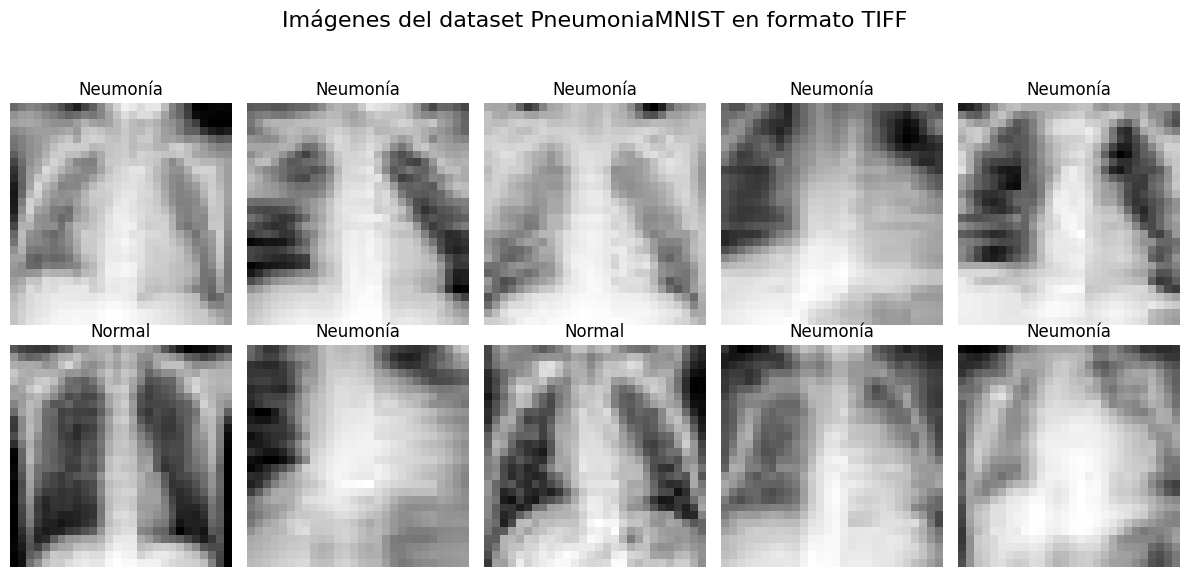

In [13]:
# Visualizar las imágenes TIFF
plt.figure(figsize=(12, 6))
for i in range(min(10, len(tiff_images))):
    plt.subplot(2, 5, i+1)
    plt.imshow(tiff_images[i], cmap='gray')
    plt.title(f"{label_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.suptitle("Imágenes del dataset PneumoniaMNIST en formato TIFF", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [15]:
# Aplicar preprocesamiento a las imágenes TIFF
processed_images = []
for img in tiff_images:
    # Asegurar tipo uint8
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
        
    # Mejora de contraste: CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(2, 2))
    equalized = clahe.apply(img)
    
    # Reducción de ruido: filtro gaussiano
    denoised = cv2.GaussianBlur(equalized, (3, 3), 0.5)
    
    processed_images.append(denoised)

processed_images = np.array(processed_images)

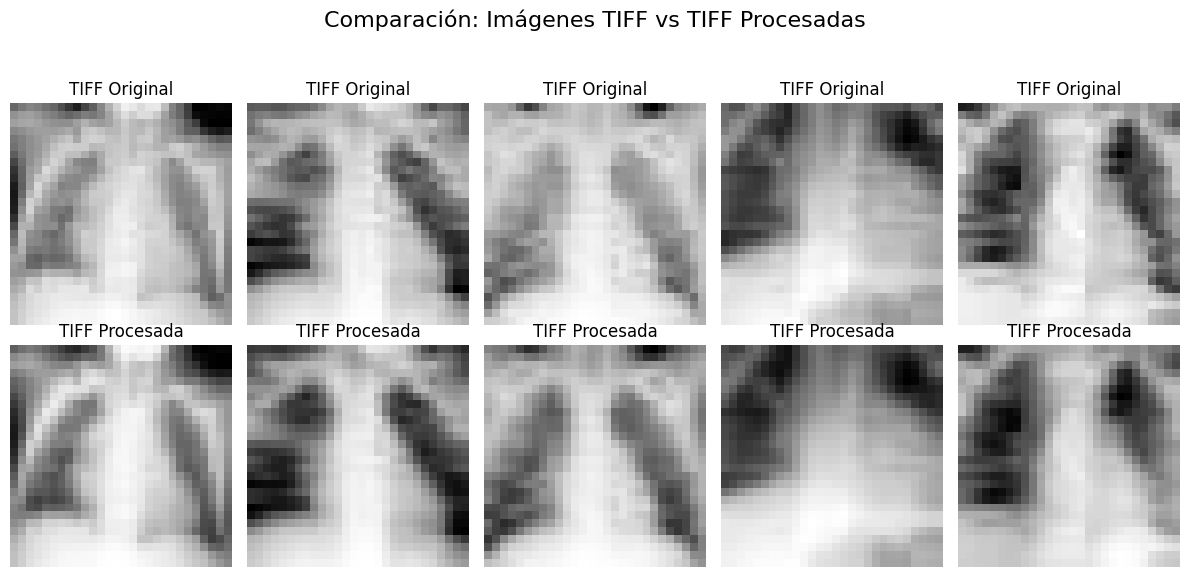

In [16]:

# Mostrar imágenes originales TIFF y procesadas
plt.figure(figsize=(12, 6))
for i in range(5):
    if i < len(tiff_images):
        # Original TIFF
        plt.subplot(2, 5, i+1)
        plt.imshow(tiff_images[i], cmap='gray')
        plt.title(f"TIFF Original")
        plt.axis('off')
        
        # Procesada
        plt.subplot(2, 5, i+6)
        plt.imshow(processed_images[i], cmap='gray')
        plt.title(f"TIFF Procesada")
        plt.axis('off')
plt.tight_layout()
plt.suptitle("Comparación: Imágenes TIFF vs TIFF Procesadas", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [17]:
# Seleccionar imágenes para segmentación (una de cada clase)
normal_indices = np.where(labels == 0)[0]
pneumonia_indices = np.where(labels == 1)[0]

normal_idx = normal_indices[0] if len(normal_indices) > 0 else 0
pneumonia_idx = pneumonia_indices[0] if len(pneumonia_indices) > 0 else 0

# Función para aplicar técnicas de segmentación
def segment_image(img):
    # 1. Umbralización
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # 2. Detección de bordes
    edges = cv2.Canny(img, 30, 100)
    
    # 3. Segmentación con GaussianMixture
    flattened_img = img.reshape(-1, 1)
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(flattened_img)
    labels_gmm = gmm.predict(flattened_img)
    segmented_gmm = labels_gmm.reshape(img.shape)
    
    # 4. Análisis de componentes conectados
    labeled = measure.label(thresh)
    
    return thresh, edges, segmented_gmm, labeled

# Aplicar segmentación a imágenes TIFF procesadas
normal_img = processed_images[normal_idx]
normal_thresh, normal_edges, normal_gmm, normal_labeled = segment_image(normal_img)

pneumonia_img = processed_images[pneumonia_idx]
pneumonia_thresh, pneumonia_edges, pneumonia_gmm, pneumonia_labeled = segment_image(pneumonia_img)


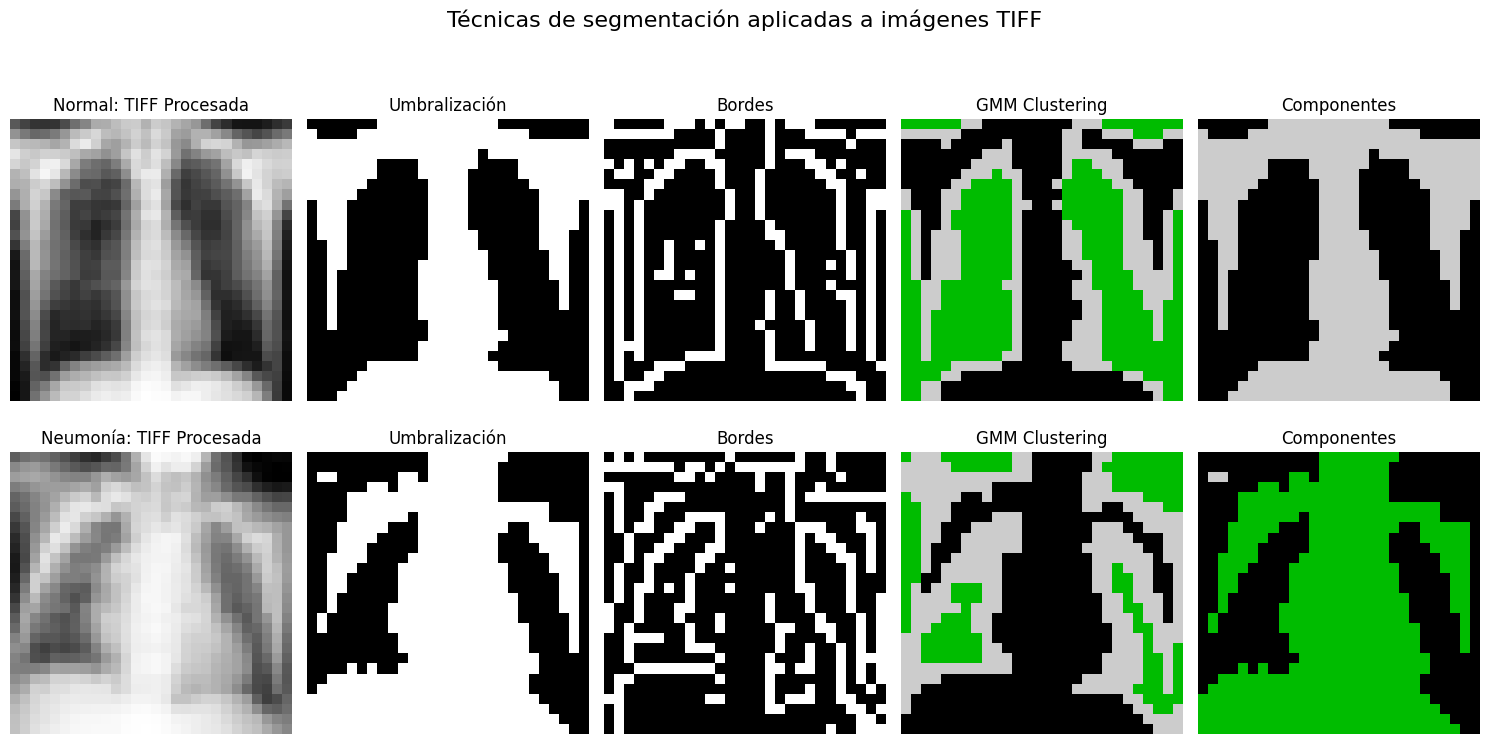


Análisis de regiones en imagen TIFF Normal:
Número de regiones encontradas: 1
Área total segmentada: 384.0 píxeles (48.98% de la imagen)
Número de regiones significativas: 1
Área promedio de regiones significativas: 384.00 píxeles
Compacidad promedio (1.0 = círculo perfecto): 0.1455

Análisis de regiones en imagen TIFF Neumonía:
Número de regiones encontradas: 2
Área total segmentada: 464.0 píxeles (59.18% de la imagen)
Número de regiones significativas: 1
Área promedio de regiones significativas: 462.00 píxeles
Compacidad promedio (1.0 = círculo perfecto): 0.2179


In [18]:

# Visualizar resultados de segmentación
plt.figure(figsize=(15, 8))

# Radiografía Normal
plt.subplot(2, 5, 1)
plt.imshow(normal_img, cmap='gray')
plt.title("Normal: TIFF Procesada")
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(normal_thresh, cmap='gray')
plt.title("Umbralización")
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(normal_edges, cmap='gray')
plt.title("Bordes")
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(normal_gmm, cmap='nipy_spectral')
plt.title("GMM Clustering")
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(normal_labeled, cmap='nipy_spectral')
plt.title("Componentes")
plt.axis('off')

# Radiografía con Neumonía
plt.subplot(2, 5, 6)
plt.imshow(pneumonia_img, cmap='gray')
plt.title("Neumonía: TIFF Procesada")
plt.axis('off')

plt.subplot(2, 5, 7)
plt.imshow(pneumonia_thresh, cmap='gray')
plt.title("Umbralización")
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(pneumonia_edges, cmap='gray')
plt.title("Bordes")
plt.axis('off')

plt.subplot(2, 5, 9)
plt.imshow(pneumonia_gmm, cmap='nipy_spectral')
plt.title("GMM Clustering")
plt.axis('off')

plt.subplot(2, 5, 10)
plt.imshow(pneumonia_labeled, cmap='nipy_spectral')
plt.title("Componentes")
plt.axis('off')

plt.tight_layout()
plt.suptitle("Técnicas de segmentación aplicadas a imágenes TIFF", fontsize=16)
plt.subplots_adjust(top=0.90)
plt.show()

# Análisis cuantitativo de las regiones segmentadas
def analyze_regions(binary_img, labeled_img, label_type):
    props = measure.regionprops(labeled_img)
    
    print(f"\nAnálisis de regiones en imagen TIFF {label_type}:")
    print(f"Número de regiones encontradas: {len(props)}")
    
    if props:
        areas = [prop.area for prop in props]
        perimeters = [prop.perimeter for prop in props]
        
        # Filtrar regiones muy pequeñas (posible ruido)
        significant_areas = [area for area in areas if area > 5]
        
        print(f"Área total segmentada: {sum(areas)} píxeles ({sum(areas)/(binary_img.shape[0]*binary_img.shape[1])*100:.2f}% de la imagen)")
        if significant_areas:
            print(f"Número de regiones significativas: {len(significant_areas)}")
            print(f"Área promedio de regiones significativas: {np.mean(significant_areas):.2f} píxeles")
        
        # Compacidad (circularidad) de las regiones: 4π×área/perímetro²
        compactness = []
        for prop in props:
            if prop.perimeter > 0 and prop.area > 5:  # Solo para regiones significativas
                comp = (4 * np.pi * prop.area) / (prop.perimeter * prop.perimeter)
                compactness.append(comp)
        
        if compactness:
            print(f"Compacidad promedio (1.0 = círculo perfecto): {np.mean(compactness):.4f}")

# Analizar las regiones segmentadas en cada tipo de imagen TIFF
analyze_regions(normal_img, normal_labeled, "Normal")
analyze_regions(pneumonia_img, pneumonia_labeled, "Neumonía")

In [19]:
# Guardar imágenes segmentadas en formato TIFF
segmentation_dir = "./pneumonia_segmentations_tiff"
if not os.path.exists(segmentation_dir):
    os.makedirs(segmentation_dir)

# Guardar resultados de segmentación
io.imsave(f"{segmentation_dir}/normal_threshold.tiff", normal_thresh)
io.imsave(f"{segmentation_dir}/normal_edges.tiff", normal_edges)
io.imsave(f"{segmentation_dir}/pneumonia_threshold.tiff", pneumonia_thresh)
io.imsave(f"{segmentation_dir}/pneumonia_edges.tiff", pneumonia_edges)

print(f"\nResultados de segmentación guardados en formato TIFF en {segmentation_dir}")
print("\nProceso completo de análisis de imágenes médicas finalizado.")


Resultados de segmentación guardados en formato TIFF en ./pneumonia_segmentations_tiff

Proceso completo de análisis de imágenes médicas finalizado.
